In [1]:
%load_ext lab_black

# Imports and constants

In [2]:
import kfp
from kfp import dsl
from kfp.components import InputPath, OutputPath
from kubernetes.client.models import (
    V1Volume,
    V1VolumeMount,
    V1PersistentVolumeClaimVolumeSource,
    V1EmptyDirVolumeSource,
)
from kfp.dsl import PipelineConf, data_passing_methods
import os
from typing import Optional, List
from typing import NamedTuple
from collections import namedtuple

COMPONENT_CATALOG_FOLDER = f"{os.getenv('HOME')}/components"

## Constants for images

These need to be set to the container images that have been built for this example.

In [3]:
BASE_IMAGE = "quay.io/ntlawrence/yolo-base:0.0.1"
APP_IMAGE = "quay.io/ntlawrence/yolo-app:0.0.1"

# Component to run one or more commands from within a container.

This is useful for setting up a workspace by running bash commands.

In [4]:
def run_commands(commands: List[str], cwd: str):
    import subprocess

    for command in commands:
        print(command)
        subprocess.run(command, shell=True, cwd=cwd)


run_commands_comp = kfp.components.create_component_from_func(
    run_commands, base_image=BASE_IMAGE
)

## Build Model component

Deploys a pytorch job that runs the python train.py script in each replica.

The train.py script uses DDP to train across multiple nodes and GPUs.

Validation metrics are returned. This example does not include test metrics. While test metrics are critical to real world applications, this example focuses on training and inferencing and does not implement that compoent. It's easy to image that test.py could also perform testing, and return those metrics as well.


In [5]:
def train_model_distributed(
    model: OutputPath(str),
    workspace_pvc_name: str,
    context: str,
    worker_image: str,
    replicas: int = 3,
    gpus: int = 1,
    workspace_mount_point: str = "/workspace",
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    import os
    import shutil
    import distributed_kf_tools.deploy as deploy
    from distributed_kf_tools.template import OwningWorkFlow, PvcMount
    import json
    from collections import namedtuple

    if gpus > 1:
        raise ValueError(
            "build_model.py does not currently support more than one GPU per node!"
        )

    devices = ",".join([str(gpu) for gpu in range(gpus)])

    ## Start the PyTorch job for distributed training
    deploy.run_pytorch_job(
        # owning_workflow setups it up so that when the pipeline is deleted,
        # the training job is cleaned up
        owning_workflow=OwningWorkFlow(
            name="{{workflow.name}}", uid="{{workflow.uid}}"
        ),
        # These place holders for namespace and job name are
        # filled in by Kubeflow when the pipeline runs.
        namespace="{{workflow.namespace}}",
        pytorch_job_name="{{workflow.name}}",
        # Shared volumes used by the training script
        # The key to the mounting is that the "runs" directory of yolov5
        # is mapped to the "/workspace/output" dir in the pvc.
        # This allows us to get to the output of the runs
        # after training (as /workspace/output in our mount of the PVC).
        pvcs=[PvcMount(pvc_name=workspace_pvc_name, mount_path="/workspace")],
        # The command to run in each worker
        # This almost always starts with "torch.distributed.run" for DDP
        command=["python", "-m", "torch.distributed.run", "build_model.py"],
        working_dir=f"{workspace_mount_point}/{context}",
        # env={
        #    "YOLO_AUTOINSTALL": "false",
        #    "YOLOV5_CONFIG_DIR": "/yolov5-config",
        #    "MPLCONFIGDIR": "/tmp/mplconfig",
        #    "NCCL_DEBUG": "TRACE",
        # },
        # Number of workers
        num_workers=replicas,
        # Number of GPUs per worker (OK to leave this at 1)
        gpus_per_worker=gpus,
        # The base image used for the worker pods
        worker_image=worker_image,
    )

    os.makedirs(os.path.dirname(model), exist_ok=True)
    # my-notebook-datavol-2/repo/distributed_training/pytorch/yolov5/src/runs/detect/train/weights/best.pt
    shutil.copyfile(
        f"{workspace_mount_point}/{context}/runs/detect/train/weights/best.pt", model
    )
    # my-notebook-datavol-2/repo/distributed_training/pytorch/yolov5/src/runs/detect/train/results.csv
    with open(f"{workspace_mount_point}/{context}/result_metrics.json", "r") as f:
        raw_metrics = json.load(f)

    metrics = {
        "metrics": [
            {
                "name": "mAP50",
                "numberValue": raw_metrics["metrics/mAP50(B)"],
                "format": "RAW",
            },
            {
                "name": "mAP50-95",
                "numberValue": raw_metrics["metrics/mAP50-95(B)"],
                "format": "RAW",
            },
        ]
    }

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])
    return out_tuple(json.dumps(metrics))


train_model_comp = kfp.components.create_component_from_func(
    train_model_distributed,
    base_image=BASE_IMAGE,
    packages_to_install=[
        "git+https://github.com/ntl-ibm/kubeflow-ppc64le-examples@yolov5-update#subdirectory=distributed_training/distributed_kf_tools"
    ],
)

## Upload the pytorch model

The upload component is the same component that is shared with other examples. It loads the pytorch model into MinIO.

In [6]:
UPLOAD_MODEL_COMPONENT = (
    f"{COMPONENT_CATALOG_FOLDER}/model-building/upload-model/component.yaml"
)

upload_model_comp = kfp.components.load_component_from_file(UPLOAD_MODEL_COMPONENT)

## Deploy an application that uses the model

Deploys a knative application that uses the model.

* The application runs under a service account with access to the secret containing MinIO credentials
* The application runs as a Knative service with scale to 0
* A GPU is allocated to the service

In [7]:
def deploy_prediction_visualizer_app(
    name: str,
    storage_uri: str,
    image: str,
    rm_existing: bool = False,
    minio_credential_secret="mlpipeline-minio-artifact",
    concurrency_target: int = 1,
    min_replicas: int = 0,
    max_replicas: int = 1,
    gpu_allocation: int = 1,
    node_selector: str = "",  # Requires admin to enable the capability
    minio_endpoint: str = "minio-service.kubeflow:9000",
):
    import subprocess
    from urllib.parse import urlparse

    # triton URL has the MINIO host in it
    # downloader doesn't like that
    # Should be formated as s3://<bucket>/<path>
    parsed_url = urlparse(storage_uri)
    s3_uri = f"{parsed_url.scheme}://{parsed_url.path.strip('/')}"

    sa_spec = f"""
    apiVersion: v1
    kind: ServiceAccount
    metadata:
      name: {name}-sa
    """

    print(sa_spec)
    subprocess.run(
        ["kubectl", "apply", "-f", "-"], input=sa_spec, check=True, text=True
    )

    ### Remove Existing Inferenceservice, if requested
    ### Ignores errrors if service does not already exist
    if rm_existing:
        subprocess.run(["kubectl", "delete", "ksvc", name], check=False)

    template_yaml = f"""
apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: {name}
  annotations:
spec:
  template:
    metadata:
      annotations:
        sidecar.istio.io/inject: "false"
        autoscaling.knative.dev/max-scale: "{max_replicas}"
        autoscaling.knative.dev/metric: concurrency
        autoscaling.knative.dev/min-scale: "{min_replicas}"
        autoscaling.knative.dev/target: "{concurrency_target}"
    spec:
      containerConcurrency: 1
      serviceAccountName: {name}-sa
      containers:
        - name: flask
          image: {image}
          imagePullPolicy: IfNotPresent
          command:
          - python
          - app.py
          securityContext:
              allowPrivilegeEscalation: false
              capabilities:
                drop:
                - ALL
              readOnlyRootFilesystem: false
              runAsNonRoot: true
              seccompProfile:
                type: RuntimeDefault
          resources:
              limits:
                cpu: "1"
                memory: 40Gi
                nvidia.com/gpu: {gpu_allocation}
              requests:
                cpu: 100m
                memory: 10Gi
          readinessProbe:
              failureThreshold: 3
              httpGet:
                path: /alive
                port: 8080
                scheme: HTTP
              periodSeconds: 30
              successThreshold: 1
              timeoutSeconds: 1
          env:
          - name: AWS_ACCESS_KEY_ID
            valueFrom: 
              secretKeyRef:
                key: accesskey
                name: {minio_credential_secret}
          - name: AWS_SECRET_ACCESS_KEY
            valueFrom:
              secretKeyRef:
                key: secretkey
                name: {minio_credential_secret}
          - name: S3_USE_HTTPS
            value: "0"
          - name: S3_ENDPOINT
            value: "{minio_endpoint}"
          - name: AWS_ENDPOINT_URL
            value: "http://{minio_endpoint}"
          - name: AWS_DEFAULT_REGION
            value: "us-west1"
          - name: awsAnonymousCredential
            value: "false"
          - name: STORAGE_URI
            value: "{s3_uri}"
          - name: CONF
            value: "0.69"
    """

    print(template_yaml)
    subprocess.run(
        ["kubectl", "apply", "-f", "-"], input=template_yaml, check=True, text=True
    )

    print("Waiting for app to become available")
    subprocess.run(
        [
            "kubectl",
            "wait",
            "--for=condition=Ready",
            f"ksvc/{name}",
            "--timeout=600s",
        ],
        check=True,
    )


# forgot to build kubectl command into the image, so using notebook image
deploy_prediction_visualizer_app_comp = kfp.components.create_component_from_func(
    deploy_prediction_visualizer_app,
    base_image="quay.io/ibm/kubeflow-notebook-image-ppc64le:elyra3.15.0-py3.9-tf2.12.0-pt2.0.1-v2",
)

## Pipeline Definition

This defines the pipeline, and the pipeline's paramters.

In [8]:
BLACKBOARD_RESOURCE_NAME = "ml-blackboard"

In [9]:
@dsl.pipeline(name="yolo-coco")
def yolo_coco(
    worker_image: str = BASE_IMAGE,
    app_image: str = APP_IMAGE,
    source_repo: str = "https://github.com/ntl-ibm/kubeflow-ppc64le-examples.git",
    source_branch: str = "yolov5-update",
    source_context: str = "distributed_training/pytorch/yolo/src",
    minio_endpoint="minio-service.kubeflow:9000",
    model_version: int = 1,
    model_name: str = "yolo",
):
    def mount_volume(task, pvc_name, mount_path, volume_subpath, read_only=False):
        task.add_volume(
            V1Volume(
                name=pvc_name,
                persistent_volume_claim=V1PersistentVolumeClaimVolumeSource(pvc_name),
            )
        )

        task.add_volume_mount(
            V1VolumeMount(
                name=pvc_name,
                mount_path=mount_path,
                sub_path=volume_subpath,
                read_only=read_only,
            )
        )

    workspace_volume_volop = dsl.VolumeOp(
        name="Create workspace for training",
        resource_name="shared-workspace-pvc",
        modes=dsl.VOLUME_MODE_RWM,
        size="4Gi",
        set_owner_reference=True,
    )

    clone_repo_task = run_commands_comp(
        [f"git clone {source_repo}  /workspace/repo -b {source_branch} || true"],
        "/workspace",
    )
    clone_repo_task.add_pvolumes({"/workspace": workspace_volume_volop.volume})
    clone_repo_task.set_display_name("Clone Repo")

    download_data_task = run_commands_comp(
        ["python download.py"], f"/workspace/repo/{source_context}"
    )
    download_data_task.add_pvolumes({"/workspace": workspace_volume_volop.volume})
    download_data_task.after(clone_repo_task)
    download_data_task.set_display_name("Download data")

    train_task = train_model_comp(
        workspace_pvc_name=workspace_volume_volop.volume.persistent_volume_claim.claim_name,
        context=f"repo/{source_context}",
        worker_image=worker_image,
    )
    train_task.add_pvolumes({"/workspace": workspace_volume_volop.volume})
    train_task.after(download_data_task)

    upload_model_task = upload_model_comp(
        train_task.outputs["model"],
        minio_url=minio_endpoint,
        export_bucket="{{workflow.namespace}}-models",
        model_name=model_name,
        model_format="pt",
        model_version=1,
    )

    deploy_prediction_visualizer_app_task = deploy_prediction_visualizer_app_comp(
        name=f"{model_name}-app",
        image=app_image,
        rm_existing=True,
        storage_uri=upload_model_task.outputs["triton_s3_address"],
        minio_endpoint=minio_endpoint,
    )

## Compile Pipeline with configuration options

Uses a PVC for passing data between components.

In [10]:
# See: https://www.kubeflow.org/docs/components/pipelines/overview/caching/#managing-caching-staleness
def disable_cache_transformer(op):
    if isinstance(op, dsl.ContainerOp):
        op.execution_options.caching_strategy.max_cache_staleness = "P0D"
    else:
        op.add_pod_annotation(
            name="pipelines.kubeflow.org/max_cache_staleness", value="P0D"
        )
    return op


pipeline_conf = PipelineConf()
pipeline_conf.add_op_transformer(disable_cache_transformer)

In [11]:
PIPELINE_NAME = "YOLO COCO pipeline"

kfp.compiler.Compiler().compile(
    pipeline_func=yolo_coco,
    package_path=f"{PIPELINE_NAME}.yaml",
    pipeline_conf=pipeline_conf,
)

## Upload pipeline programmatically

The YAML file generated by the previous compile can be used to create a pipeline through the UI.
* Download the file to your workstation
* Click "Pipelines" from the side bar
* Press the "upload pipeline" button, and upload the YAML.

After adding the pipline, you can run the pipeline from the UI without looking at the pipeline code. This allows an inexperienced user to run the pipeline with specific parameters, without the compelxity of Kubeflow componet code or K8S Awareness.

These next few cells upload and run the pipeline programmatically, so that the example is "automated".

In [12]:
def delete_pipeline(pipeline_name: str):
    """Delete's a pipeline with the specified name"""

    client = kfp.Client()
    existing_pipelines = client.list_pipelines(page_size=999).pipelines
    matches = (
        [ep.id for ep in existing_pipelines if ep.name == pipeline_name]
        if existing_pipelines
        else []
    )
    for id in matches:
        client.delete_pipeline(id)


def get_experiment_id(experiment_name: str) -> str:
    """Returns the id for the experiment, creating the experiment if needed"""
    client = kfp.Client()
    existing_experiments = client.list_experiments(page_size=999).experiments
    matches = (
        [ex.id for ex in existing_experiments if ex.name == experiment_name]
        if existing_experiments
        else []
    )

    if matches:
        return matches[0]

    exp = client.create_experiment(experiment_name)
    return exp.id

In [13]:
# Pipeline names need to be unique, so before we upload,
# check for and delete any pipeline with the same name
delete_pipeline(PIPELINE_NAME)

In [14]:
# upload the pipeline
client = kfp.Client()
uploaded_pipeline = client.upload_pipeline(f"{PIPELINE_NAME}.yaml", PIPELINE_NAME)

## Run the pipeline with parameters

This is equivalent to running the pipeline from the pipelines view in the UI. Since a pipeline run needs to be part of an experiment, this code will create the experiment if it does not exist.

When we run this manually, we'll use initial weights that have been trained on a much larger superset of this data, and with many more epochs. That will give us results that can be demoed with a fast training cycle.

In [15]:
pipeline_params = {}

run = client.run_pipeline(
    experiment_id=get_experiment_id("coco128"),
    job_name="coco128",
    pipeline_id=uploaded_pipeline.id,
    params=pipeline_params,
)

## Waits for the pipeline to complete 

* waits for up to 20 Min
* Checks the results

In [16]:
TWENTY_MIN = 20 * 60
result = client.wait_for_run_completion(run.id, timeout=TWENTY_MIN)
{
    "status": result.run.status,
    "error": result.run.error,
    "time": str(result.run.finished_at - result.run.created_at),
}

assert result.run.status != "Failed"

# Test Application (Inference)

The inference application is deployed. We can now test our object detection applcation


## Setup

In [17]:
with open("/var/run/secrets/kubernetes.io/serviceaccount/namespace") as n:
    NAMESPACE = n.read()

In [18]:
import requests
from PIL import Image
import io

## Download a test image

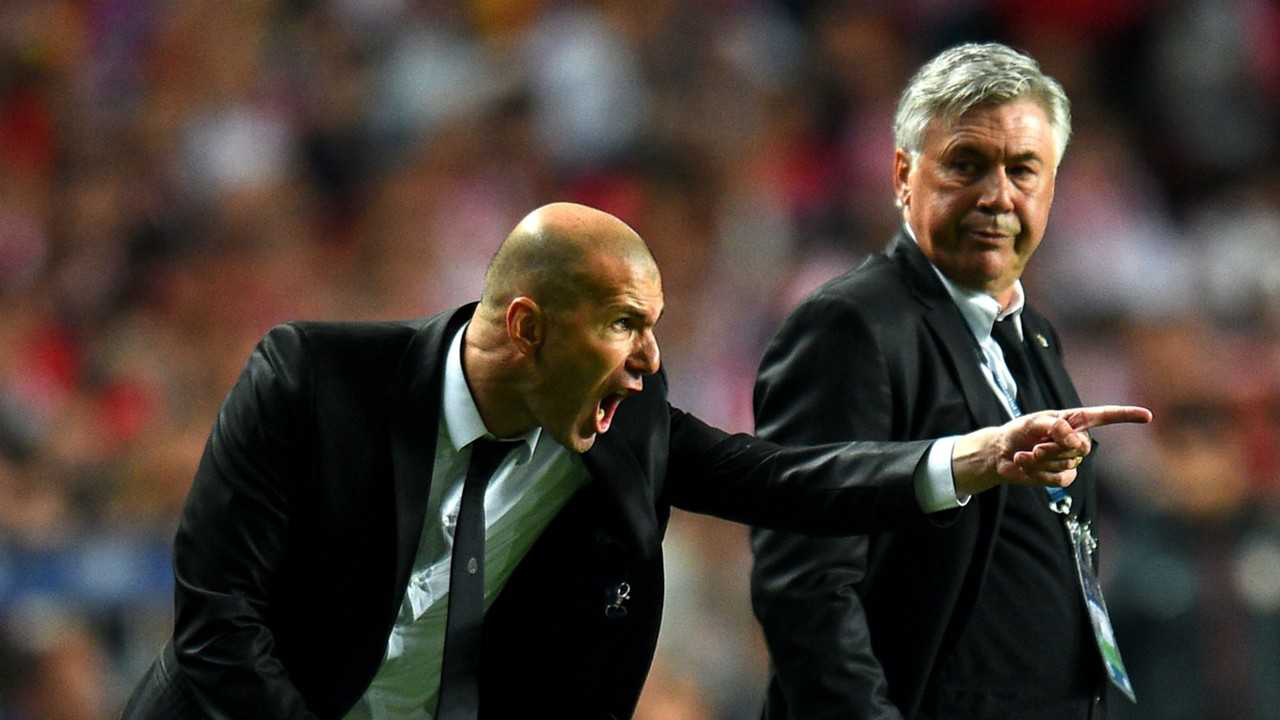

In [19]:
response = requests.get(
    "https://github.com/ultralytics/ultralytics/blob/main/ultralytics/assets/zidane.jpg?raw=true"
)
image = Image.open(io.BytesIO(response.content))

image.show()

## Predict objects

In [20]:
raw_image = io.BytesIO()
image.save(raw_image, format="JPEG")
detect_rsp = requests.post(
    f"http://yolo-app.{NAMESPACE}.svc.cluster.local/detect",
    headers={"Content-Type": "image/jpeg", "Accept": "image/jpeg"},
    data=io.BytesIO(raw_image.getvalue()),
)

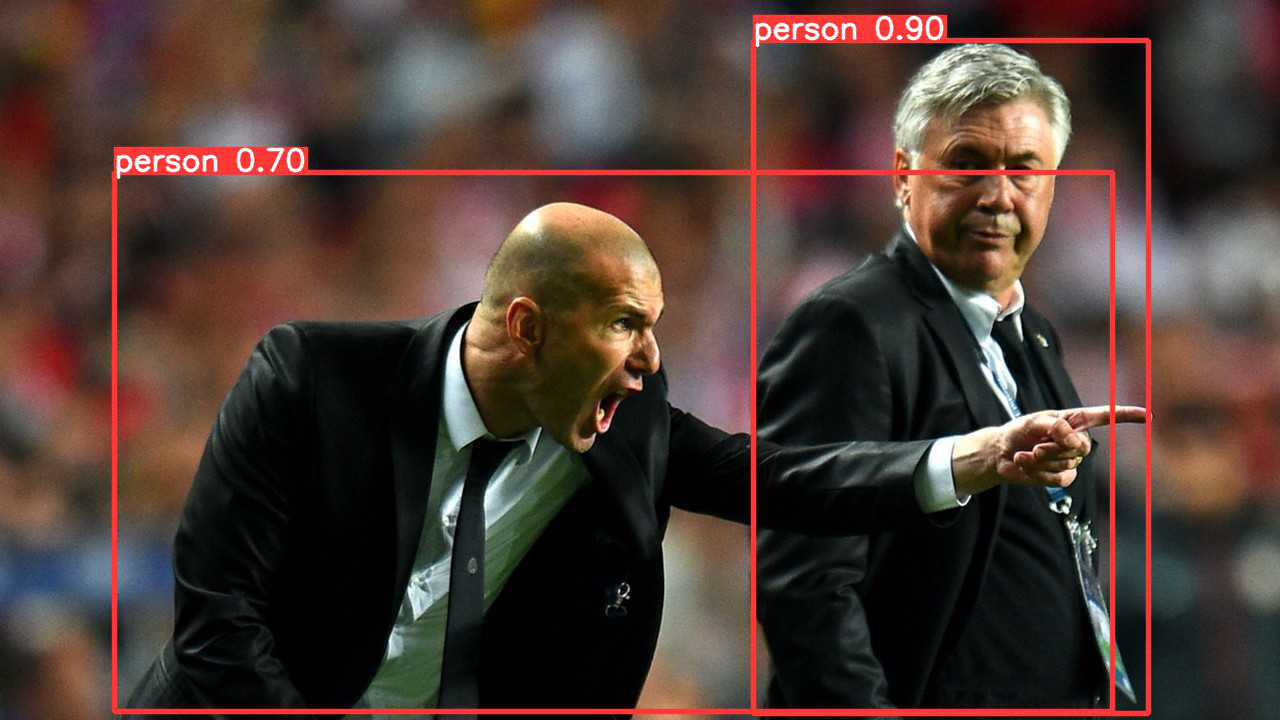

In [22]:
detect_image = Image.open(io.BytesIO(detect_rsp.content), formats=("JPEG",))

detect_image.show()